In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error

import ase.io
from ase.geometry import wrap_positions
from time import time


# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion

from rascalLodeCombinator import rascalLodeCombinator

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter

In [30]:
def rmse(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [31]:
train_frames = ase.io.read("P_GAP_20_fitting_data_one_tenth.xyz", "80:")
        
train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])


test_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

test_energy = np.array([
    frame.info["energy"] for frame in test_frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in test_frames
])

In [32]:
hypers_lr = {
    'smearing':1.4,#0.7 1.0
    'max_angular':0,
    'max_radial':10,
    'cutoff_radius':5.,
    'potential_exponent':1,
    'radial_basis': 'gto',
    'compute_gradients':True
}

# hypers_lr = {
#     'smearing':0.7,
#     'max_angular':6,
#     'max_radial':6,
#     'cutoff_radius':5.,
#     'potential_exponent':1,
#     'radial_basis': 'gto',
#     'compute_gradients':True
# }

hypers_rascaline = {
    "cutoff": 4.5,
    "atomic_gaussian_width": 0.2,
    "max_radial": 10,
    "max_angular": 10,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 1.5}},
    "gradients": True
}

alpha = 0.0016681005372000592

In [33]:
### Non powerspectrum lode
start = time()

calculator_lode = PyLODESphericalExpansion(hypers_lr)

train_lode = calculator_lode.compute(train_frames)

train_lode.components_to_properties(['spherical_harmonics_m'])
train_lode.keys_to_properties(['neighbor_species','spherical_harmonics_l'])
train_lode.keys_to_samples('center_species')

print('Calculation time:'+str(time()-start))

Calculation time:3.6100521087646484


In [34]:
start = time()

calculator_rascaline = RascalineSphericalExpansion(hypers_rascaline)
train_rascaline = calculator_rascaline.compute(train_frames)
ps_train_rascaline = compute_power_spectrum(train_rascaline)

ps_train_rascaline.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
ps_train_rascaline.keys_to_samples('center_species')

print('Calculation time:'+str(time()-start))

Calculation time:18.509882926940918


In [35]:
train_merged = rascalLodeCombinator(train_lode, ps_train_rascaline,alpha=alpha)

In [36]:
print(train_lode.block().values)
print(ps_train_rascaline.block().values)

[[ 0.01131085  0.01180597  0.00428208 ... -0.07417286 -0.02108567
  -0.00525723]
 [ 0.01712837  0.01870985  0.01552303 ... -0.08079822 -0.03772379
  -0.00030574]
 [ 0.01458056  0.01566958  0.01040023 ... -0.07569895 -0.03011915
  -0.00421187]
 ...
 [ 0.00949911  0.01094076  0.01555068 ... -0.00512907 -0.03383963
   0.00475381]
 [ 0.03454806  0.03976496  0.05371081 ... -0.0590718   0.08609956
   0.02157656]
 [ 0.03454806  0.03976496  0.05371081 ... -0.0590718   0.08609956
   0.02157656]]
[[ 9.36653848e-03 -2.29408641e-03  1.71539264e-04 ...  1.24291794e-05
   6.05475475e-06  2.13981097e-06]
 [ 9.34819739e-03 -2.27385452e-03  1.29652256e-04 ...  1.29279822e-05
   6.20690385e-06  2.18766115e-06]
 [ 9.35352613e-03 -2.27957755e-03  1.42862133e-04 ...  1.29793294e-05
   6.18627895e-06  2.18367050e-06]
 ...
 [ 9.09041356e-03 -2.01809727e-03 -5.03313810e-04 ...  1.03468145e-04
   4.60331595e-05  1.52514842e-05]
 [ 9.41040168e-03 -2.33402247e-03  2.34911951e-04 ...  1.50323472e-05
   8.66105054

In [37]:
### Linear model

start = time()

model = LinearModel(do_normalize=False, regularizer=[1.25e-4,1.25e-2])
model.fit(train_merged, train_energy, train_forces)
pred_energy, pred_forces = model.predict(train_merged, with_forces=True)

print('time: '+str(time()-start))

time: 81.94291758537292


In [38]:
train_energy_per_atom=[]
pred_energy_per_atom=[]

for i in np.arange(len(train_frames)):
    n_atoms = len(train_frames[i])
    train_energy_per_atom.append(train_energy[i]/n_atoms)
    pred_energy_per_atom.append(pred_energy[i]/n_atoms)

train_energy_per_atom=np.array(train_energy_per_atom)
pred_energy_per_atom=np.array(pred_energy_per_atom)

print('Energy RMSE (eV/atom) of the rascaline+pyLODE model is:')
print(rmse(train_energy_per_atom, pred_energy_per_atom))
print('Forces RMSE (eV/A) of the rascaline+pyLODE model is:')
print(rmse(train_forces.flatten(), pred_forces.flatten()))

Energy RMSE (eV/atom) of the rascaline+pyLODE model is:
[0.05417908]
Forces RMSE (eV/A) of the rascaline+pyLODE model is:
0.482309535321975


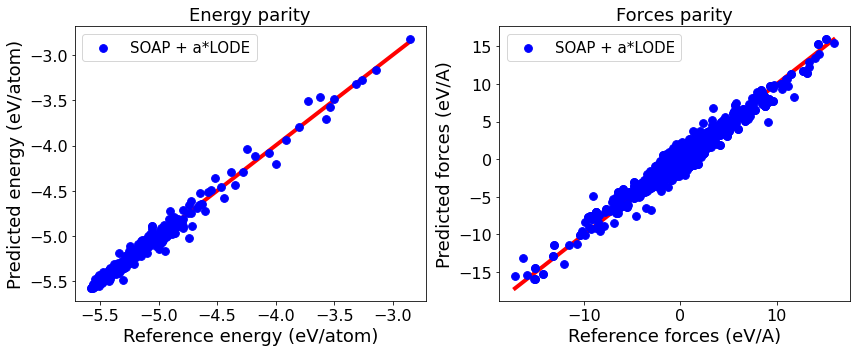

In [39]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
x = [train_energy_per_atom.min(), train_energy_per_atom.max()]
ax[0].set_title('Energy parity',fontsize=18)
ax[0].set_xlabel('Reference energy (eV/atom)',fontsize=18)
ax[0].set_ylabel('Predicted energy (eV/atom)',fontsize=18)
ax[0].tick_params(labelsize=16)
ax[0].plot(x, x, color="r",linewidth=4)
ax[0].scatter(train_energy_per_atom, pred_energy_per_atom,color='blue',label='SOAP + a*LODE',zorder=3,s=60)
ax[0].legend(markerscale=1,fontsize=15)


xx = [train_forces.flatten().min(), train_forces.flatten().max()]
ax[1].set_title('Forces parity',fontsize=18)
ax[1].set_xlabel('Reference forces (eV/A)',fontsize=18)
ax[1].set_ylabel('Predicted forces (eV/A)',fontsize=18)
ax[1].tick_params(labelsize=16)
ax[1].plot(xx, xx, color="r",linewidth=4)
ax[1].scatter(train_forces.flatten(), pred_forces.flatten(),color='blue',label='SOAP + a*LODE',zorder=3,s=60)
ax[1].legend(markerscale=1,fontsize=15)

plt.tight_layout()


In [40]:
### test of the model on exfoliation frames

In [41]:
### Non power spectrum lode

start = time()

calculator_lode = PyLODESphericalExpansion(hypers_lr)

test_lode = calculator_lode.compute(test_frames)

test_lode.components_to_properties(['spherical_harmonics_m'])
test_lode.keys_to_properties(['neighbor_species','spherical_harmonics_l'])
test_lode.keys_to_samples('center_species')

print('Calculation time:'+str(time()-start))

Calculation time:0.5005788803100586


In [42]:
start = time()

calculator_rascaline = RascalineSphericalExpansion(hypers_rascaline)
test_rascaline = calculator_rascaline.compute(test_frames)
ps_test_rascaline = compute_power_spectrum(test_rascaline)

ps_test_rascaline.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
ps_test_rascaline.keys_to_samples('center_species')

print('Calculation time:'+str(time()-start))

Calculation time:1.4998939037322998


In [43]:
test_merged = rascalLodeCombinator(test_lode, ps_test_rascaline,alpha=alpha)

In [44]:
pred_energy_test, pred_forces_test = model.predict(test_merged, with_forces=True)

In [45]:
test_energy_per_atom=[]
pred_energy_test_per_atom=[]

for i in np.arange(len(test_frames)):
    n_atoms = len(test_frames[i])
    test_energy_per_atom.append(test_energy[i]/n_atoms)
    pred_energy_test_per_atom.append(pred_energy_test[i]/n_atoms)

test_energy_per_atom=np.array(test_energy_per_atom)
pred_energy_test_per_atom=np.array(pred_energy_test_per_atom)

print('Energy RMSE (eV/atom) of the rascaline+pyLODE model is:')
print(rmse(test_energy_per_atom, pred_energy_test_per_atom))
print('Forces RMSE (eV/A) of the rascaline+pyLODE model is:')
print(rmse(test_forces.flatten(), pred_forces_test.flatten()))

Energy RMSE (eV/atom) of the rascaline+pyLODE model is:
[0.0030198]
Forces RMSE (eV/A) of the rascaline+pyLODE model is:
0.16915565490319467


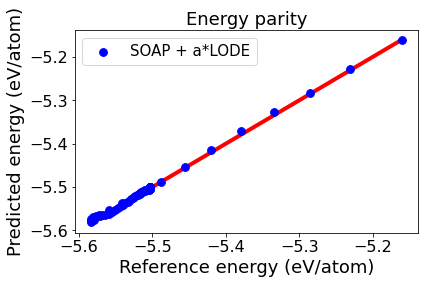

In [46]:
fig, ax = plt.subplots()
x = [test_energy_per_atom.min(), test_energy_per_atom.max()]
ax.set_title('Energy parity',fontsize=18)
ax.set_xlabel('Reference energy (eV/atom)',fontsize=18)
ax.set_ylabel('Predicted energy (eV/atom)',fontsize=18)
ax.tick_params(labelsize=16)
ax.plot(x, x, color="r",linewidth=4)
ax.scatter(test_energy_per_atom, pred_energy_test_per_atom,color='blue',label='SOAP + a*LODE',zorder=3,s=60)
ax.legend(markerscale=1,fontsize=15)

plt.tight_layout()

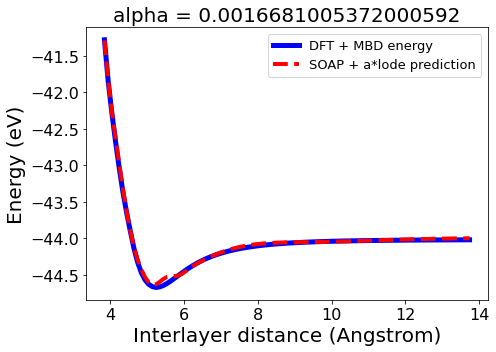

In [47]:
dist_list = []

for i in np.arange(len(test_frames)):
    dist = test_frames[i].get_positions()[0,1]-test_frames[i].get_positions()[6,1]
    dist_list.append(dist)

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Energy (eV)',fontsize=20)
ax.tick_params(labelsize=16)
ax.set_title('alpha = '+str(alpha),fontsize=20)

ax.plot(dist_list, test_energy,'-',label='DFT + MBD energy',linewidth=5,color='blue')
ax.plot(dist_list, pred_energy_test,'--',label='SOAP + a*lode prediction',linewidth=4,color='red')

ax.legend(markerscale=2,fontsize=13)

plt.tight_layout()